# Imports

In [2]:
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt
import re

# Data parcing

In [3]:
file_path = "d=4\DataCplex_density=1_p=10_h=15_test_0.dat"


def Extract(file_path=None, d=1, p=10, h=15, t=0):
    if file_path is not None:
        with open(file_path, "r", encoding="utf-8") as f:
            data = f.readlines()  # Liste des lignes du fichier
    else:
        file_path = (
            f"d={d}\\p={p}\\h={h}\\DataCplex_density={d}_p={p}_h={h}_test_{t}.dat"
        )
        with open(file_path, "r", encoding="utf-8") as f:
            data = f.readlines()  # Liste des lignes du fichier
    data_dict = {i: list() for i in range(11)}
    
    i = 0
    for line in data:
        data_dict[i].append(line)
        if line[len(line) - 2 :] == ";\n":
            i += 1
    for x in range(11):
        for i in range(len(data_dict[x])):
            data_dict[x][i] = data_dict[x][i][: len(data_dict[x][i]) - 1]
            
    


    #(Departure/Arrival) (Airports/Times)
    
    AeroDep = {}
    AeroArr = {}
    DateDep = {}
    DateArr = {}
    Flightdate={}

    for i in range(1, len(data_dict[5])):
        values = data_dict[5][i].strip("<>;{}").split(",")
        AeroDep[i] = values[1]
        AeroArr[i] = values[2]
        DateDep[i] = float(values[3])
        DateArr[i] = float(values[4])
        Flightdate[i]=int(values[5])
        

    # Aeroports

    Aero = data_dict[0][0].split("{")[1].split("}")[0].strip(",").split(",")
    Aero=set(Aero)
    #Aero maintenance
    
    Aero_maint = data_dict[1][0].split("{")[1].split("}")[0].strip(",").split(",")
    Aero_maint=set(Aero_maint)
    # Aircrafts

    Aircrafts_str = data_dict[3][0].split("{")[1].split("}")[0].strip(",").split(",")
    Aircrafts = range(int(Aircrafts_str[-1]) + 1)
    
    
    # Flights

    NbFlights = int(data_dict[2][0].split("=")[1].split(";")[0])
    Flights = range(1, NbFlights + 1)
    
    
    #Days
    
    Days_str=data_dict[4][0].split("{")[1].split("}")[0].strip(",").split(",")
    Days = range(int(Days_str[-1]) + 1)

    # Cost

    cost = {}
    for i in range(len(Aircrafts)):
        for j in range(1, len(data_dict[6])):
            q = 0
            for k in range(len(data_dict[6][j])):
                if data_dict[6][j][k] == ",":
                    cost[(i, j)] = data_dict[6][j][q + 1 : k]
                    cost[(i, j)] = float(cost[(i, j)])
                    q = k
    
    #cost maintenance
    cost_maint_ = {}
    A=[] 
    for j in range(1,len(data_dict[7])):
        q = 0
        for k in range(len(data_dict[7][j])):
            if data_dict[7][j][k] == ",":
                A.append(float(data_dict[7][j][q+1 : k]))
                break
    for i in range(len(Aircrafts)):
        cost_maint_[(i, 0)] = A[i]                         
                                    
    for i in range(len(Aircrafts)):
        for j in range(1,len(data_dict[7])):
            q = 0
            for k in range(len(data_dict[7][j])):
                if data_dict[7][j][k] == ",":
                    cost_maint_[(i, j)] = float(data_dict[7][j][q+1 : k])
                    q = k
    cost_maint = {}
    for i,j in cost_maint_.keys():
       cost_maint[(i,list(Aero_maint)[j])]=cost_maint_[(i,j)]
    
    #cap maintenance
    
    cap_maint = int(data_dict[8][0].split("=")[1].split(";")[0])
    
    
    #horizon
    horizon = int(Flightdate[NbFlights])
    
    
    #Origin
    Origin_str = str(data_dict[10][1])
    Origin_str = Origin_str.strip("[] ").split(" ,")
    Origin_str=Origin_str[:-1]

    
    # Construire le dictionnaire
    Origin = {int(pair.strip("<>").split(",")[0]): pair.strip("<>").split(",")[1] for pair in Origin_str}
    

    
        
    
    return Aero, Aero_maint, Aircrafts, Flights, Days, AeroDep, AeroArr, DateDep, DateArr, Flightdate, cost, cost_maint, cap_maint, horizon, Origin

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20896\253188019.py:1: SyntaxWarning: invalid escape sequence '\D'
  file_path = "d=4\DataCplex_density=1_p=10_h=15_test_0.dat"


In [4]:
file_path_sol = "d=4\Optimal_Solution_density=1_p=10_h=15_test_0.txt"
Aero, Aero_maint, Aircrafts, Flights, Days, AeroDep, AeroArr, DateDep, DateArr, Flightdate, cost, cost_maint, cap_maint, horizon, Origin = Extract(d=1, p=10, h=15, t=0, file_path=file_path)

<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:1: SyntaxWarning: invalid escape sequence '\O'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20896\3964277178.py:1: SyntaxWarning: invalid escape sequence '\O'
  file_path_sol = "d=4\Optimal_Solution_density=1_p=10_h=15_test_0.txt"


In [5]:
def Extract_cost_from_sol(file_path_sol=None,a=4, d=0.5, p=10, h=7, t=0):
    flight_assignments_sol = {}
    aircraft = None
    count=0
    if file_path_sol is None:
        file_path_sol = (
            f"d={a}\\Optimal_Solution_density={d}_p={p}_h={h}_test_{t}.dat"
        )
    with open(file_path_sol, 'r', encoding='latin-1') as file:
        for line in file:
            if "Flights assigned to aircraft" in line:
                aircraft = int(re.search(r'\d+', line).group())
            elif "Flight n°" in line:
                match = re.search(r'<(\d+)\s+"(\w+)"\s+"(\w+)"\s+(\d+)\s+(\d+)\s+(\d+)> (\d+)', line)
                if match:
                    flight_id, dep, arr, dep_time, arr_time, day = match.groups()[:6]
                    flight_assignments_sol[int(flight_id)] = {
                        'aircraft': aircraft,
                        'departure_airport': dep,
                        'arrival_airport': arr,
                        'departure_time': int(dep_time),
                        'arrival_time': int(arr_time)
                    }
    cost_mat=cost
    final_cost=0
    for i in flight_assignments_sol:
        aircraft = flight_assignments_sol[i]['aircraft']
        final_cost+=cost_mat[(aircraft,i)]
    return final_cost

print(Extract_cost_from_sol(file_path_sol=file_path_sol))

3338562.0


# Defining the model's parameters 

In [6]:
Aero, Aero_maint, Aircrafts, Flights, Days, AeroDep, AeroArr, DateDep, DateArr, Flightdate, cost, cost_maint, cap_maint, horizon, Origin = Extract(d=1, p=10, h=15, t=0, file_path=file_path)

In [7]:
n=4 ; no_AM = len(Aero_maint)

# Some useful functions for resolution

As per our report, we make use of certain sets to define the constraints. The definitions are rather simple and are detailed below.
We added new functions to the old ones defined in the first part of the project.

In [8]:
# Dj: the set of flights departing from the same airport as flight j
def D(j):
    L=[]
    for k in Flights:
        if AeroDep[j]== AeroDep[k] and k !=j:
            L.append(k)
    return set(L)


# Aa,j+: the set of flights arriving after the arrival time of flight j
def A_a_plus(j):
    L = []
    for k in Flights:
        if DateArr[k] >= DateArr[j] and k != j:
            L.append(k)
    return set(L)


# Aa,j-: the set of flights arriving before the arrival time of flight j
def A_a_minus(j):
    L = []
    for k in Flights:
        if DateArr[k] <= DateArr[j] and k != j:
            L.append(k)
    return set(L)


# Ad,j+: the set of flights arriving after the departure time of flight j
def A_d_plus(j):
    L = []
    for k in Flights:
        if DateArr[k] >= DateDep[j] and k != j:
            L.append(k)
    return set(L)


# Ad,j-: the set of flights arriving before the departure time of flight j
def A_d_minus(j):
    L = []
    for k in Flights:
        if DateArr[k] <= DateDep[j]:
            L.append(k)
    return set(L)


# Da,j+: the set of flights departing after the arrival time of flight j
def D_a_plus(j):
    L = []
    for k in Flights:
        if DateDep[k] >= DateArr[j]:
            L.append(k)
    return set(L)


# Da,j-: the set of flights departing before the arrival time of flight j
def D_a_minus(j):
    L = []
    for k in Flights:
        if DateDep[k] <= DateArr[j] and k != j:
            L.append(k)
    return set(L)


# Dd,j+: the set of flights departing after the depature time of flight j
def D_d_plus(j):
    L = []
    for k in Flights:
        if DateDep[k] >= DateDep[j] and k != j:
            L.append(k)
    return set(L)


# Dd,j-: the set of flights departing before the departure time of flight j
def D_d_minus(j):
    L = []
    for k in Flights:
        if DateDep[k] <= DateDep[j] and k != j:
            L.append(k)
    return set(L)



# Co_j: the set of flights connecting onward with flight j,  i.e. having the same departure airport as the arrival airport as flight j ∈ {1, ..., V } (regardless of the time)


def Co(j):
    L = []


    for k in Flights:

        if AeroDep[k] == AeroArr[j]:

            L.append(k)

    return set(L)


# Co_j-: the set of flights connecting backward with flight j,  i.e. having the same arrival airport as the departure airport as flight j ∈ {1, ..., V } (regardless of the time)


def Co_minus(j):
    L = []

    for k in Flights:

        if AeroArr[k] == AeroDep[j]:

            L.append(k)

    return set(L)



# Oi: the set of flights departing from the origin airport oi of airplane i ∈ {1, ..., A}.


def O(i):
    L = []


    for k in Flights:

        if Origin[i] == AeroDep[k]:

            L.append(k)

    return set(L)

# M: the set of flights landing in a maintenance airport

def M():
    M=[]
    for j in Flights:
        if AeroArr[j] in Aero_maint:
            M.append(j)
    return set(M)

# Nn: the set of flights with a flight later than n days 

def Nn():
    Nn=[]
    for j in M():
        Flag=False
        for k in Flights:
            if DateArr[k]>DateDep[j] + n * 1440:
                Flag=True
        if Flag:
            Nn.append(j)
    return set(Nn)

# N_plus_n(j) : the set of flights that arrive at most n days later than the departure of flight j

def N_plus_n(j):
    N_plus_n_j=[]
    for k in M():
        if DateArr[k]>=DateDep[j] and DateArr[k]<=DateDep[j] + n*1440:
            N_plus_n_j.append(k)
    return set(N_plus_n_j)

# nM_plus(j) : the set of flights departing before the maintenance time interval and after the arrival of j
    
def nM_plus(j):
    nM_plus_j=[]
    if DateArr[j]%1440>=1320 or DateArr[j]%1440<=360:
        return set()
    for k in Flights:
        if DateDep[k]>=DateArr[j] and AeroDep[k]==AeroArr[j] and DateDep[k]<1440*Flightdate[j]+1320:
            nM_plus_j.append(k)
    return set(nM_plus_j)

# A_a_m : the set 

def A_a_m(a,m):
    A_a_m=[]
    if m==0:
        for j in M():
            if AeroArr[j]==a and DateDep[j]<360:
                A_a_m.append(j)
        return set(A_a_m)
    else:
        for j in M():
            if AeroArr[j]==a and DateDep[j]>=1440*m+360 and DateDep[j]<1440*m+1800:
                A_a_m.append(j)
        return set(A_a_m)

    
    
# A_a : the set of maintenance flights sharing the same arrival airport    
    
def A_a(a):
    A_a=[]
    for j in M():
        if AeroArr[j]==a:
            A_a.append(j)
    return set(A_a)
    
# J_m : the set of flights departing on the same day that are compatible with maintenance

def J_m(d):
    J_m=[]
    for j in M():
        if Flightdate[j]==d:
            J_m.append(j)
    return set(J_m)

# Testing on the given data

In [9]:
file_path = "d=4\DataCplex_density=1_p=10_h=15_test_0.dat"
Aero, Aero_maint, Aircrafts, Flights, Days, AeroDep, AeroArr, DateDep, DateArr, Flightdate, cost, cost_maint, cap_maint, horizon, Origin = Extract(file_path=file_path)

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20896\2789406811.py:1: SyntaxWarning: invalid escape sequence '\D'
  file_path = "d=4\DataCplex_density=1_p=10_h=15_test_0.dat"


# Note :

The encoding of the problem below does not run in reasonable time (we have left the solver to run for 2 hours without reaching a feasible solution). We are still trying to change the model in a way that reduces the problem complexity, if possible...

In [ ]:
m = Model("Test 2.1")
X = {
    (i, j): m.addVar(vtype=GRB.BINARY, name="x" + str(i)+ " " + str(j))
    for i in Aircrafts
    for j in Flights
}

Z = {(i,j) : m.addVar(vtype=GRB.BINARY, name="z"+ str(i)+ " " + str(j)) for i in Aircrafts for j in M()}


# -- Uniqueness of airplane assignment to flights
for j in Flights:
    m.addConstr(quicksum([X[(i, j)] for i in Aircrafts]) == 1, name="U" + str(j))

# -- Continuity of Flights for non origins
for i in Aircrafts:
    for j in Flights:
        if j not in O(i):
            m.addConstr(quicksum([X[(i,k)] for k in Co_minus(j)&A_d_minus(j)]+[X[(i,l)]*(-1) for l in D(j)&D_d_minus(j)]+[X[(i,j)]*(-1)])>=0, name="C "+str(i) + " " + str(j))

# -- Departure / continuity for potential origins
for i in Aircrafts:
    for j in O(i):
        m.addConstr(quicksum([X[(i,k)] for k in Co_minus(j)&A_d_minus(j)]+[X[(i,l)]*(-1) for l in D(j)&D_d_minus(j)]+[X[(i,j)]*(-1)])>=-1, name="Co "+str(i) + " " + str(j))



# -- Schedule Regularity
for i in Aircrafts:
    for h in range(1,horizon-n):
        l=[]
        for cmpt in range (n):
            l+=[Z[(i,k)] for k in J_m(h+cmpt)]
        m.addConstr(quicksum(l)>=1, name="SR "+str(i) + " " + str(h))


# -- Airport Capacity
for mm in range(horizon):
    for a in Aero_maint:
            m.addConstr(quicksum([Z[(i,k)] for i in Aircrafts for k in A_a_m(a,mm)])<=cap_maint, name="Cap "+ str(a) + " " + str(m))        

# -- Travel and Maintenance Coherence
for i in Aircrafts:
    for j in M():
        count=0
        m.addConstr(quicksum([Z[(i,j)], (-1)*X[(i,j)]])<=0, name="Coh" + str(i) + " " + str(j)+ " " + str(count))
        for k in nM_plus(j):
            count+=1
            m.addConstr(quicksum([Z[(i,j)], X[(i,k)]])<=1, name="Coh" + str(i) + " " + str(j) + " " + str(count))    
        
        



lz=[]
for i in Aircrafts:
    for a in Aero_maint:
        for j in A_a(a):
            lz.append(Z[(i,j)]*cost_maint[(i,a)])
            

# Objective Function
m.setObjective(
    quicksum([X[(i, j)] * cost[(i, j)] for i in Aircrafts for j in Flights]+lz), GRB.MINIMIZE
)
m.update()

m.write("Test2.1.lp")


m.optimize()
if m.status == GRB.INFEASIBLE:
    print("Le modèle n'a pas de solution. Voici les contraintes le rendant ainsi")
    m.computeIIS()
    for c in m.getConstrs():
        if c.IISConstr: print(f'\t{c.constrname}: {m.getRow(c)} {c.Sense} {c.RHS}')
elif m.status == GRB.UNBOUNDED:
    print("Le modèle est non borné")
else:
    print("Le coût à l'optimal a pour valeur: ", m.ObjVal)

print(m.getVars())

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20613 rows, 7540 columns and 226430 nonzeros
Model fingerprint: 0xe4cb513b
Variable types: 0 continuous, 7540 integer (7540 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+03, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 6193 rows and 1381 columns
Presolve time: 1.11s
Presolved: 14420 rows, 6159 columns, 129406 nonzeros
Variable types: 0 continuous, 6159 integer (6159 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    8658    3.4732080e+06   5.344159e+03   0.000000e+00      5s
   14671    3.4732080e+06   0.000000e+00   0.000000e+00     10s

Root relaxation: objective 3.473208e+06, 14

KeyboardInterrupt: 

Exception ignored in: 'gurobipy._core.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\ipykernel\iostream.py", line 655, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]

KeyboardInterrupt: 


     0     0 3473494.33    0 1160 3505228.00 3473494.33  0.91%     -  193s
     0     0 3473494.33    0 1147 3505228.00 3473494.33  0.91%     -  195s


Let's now plot the flights and the maitenances :

True


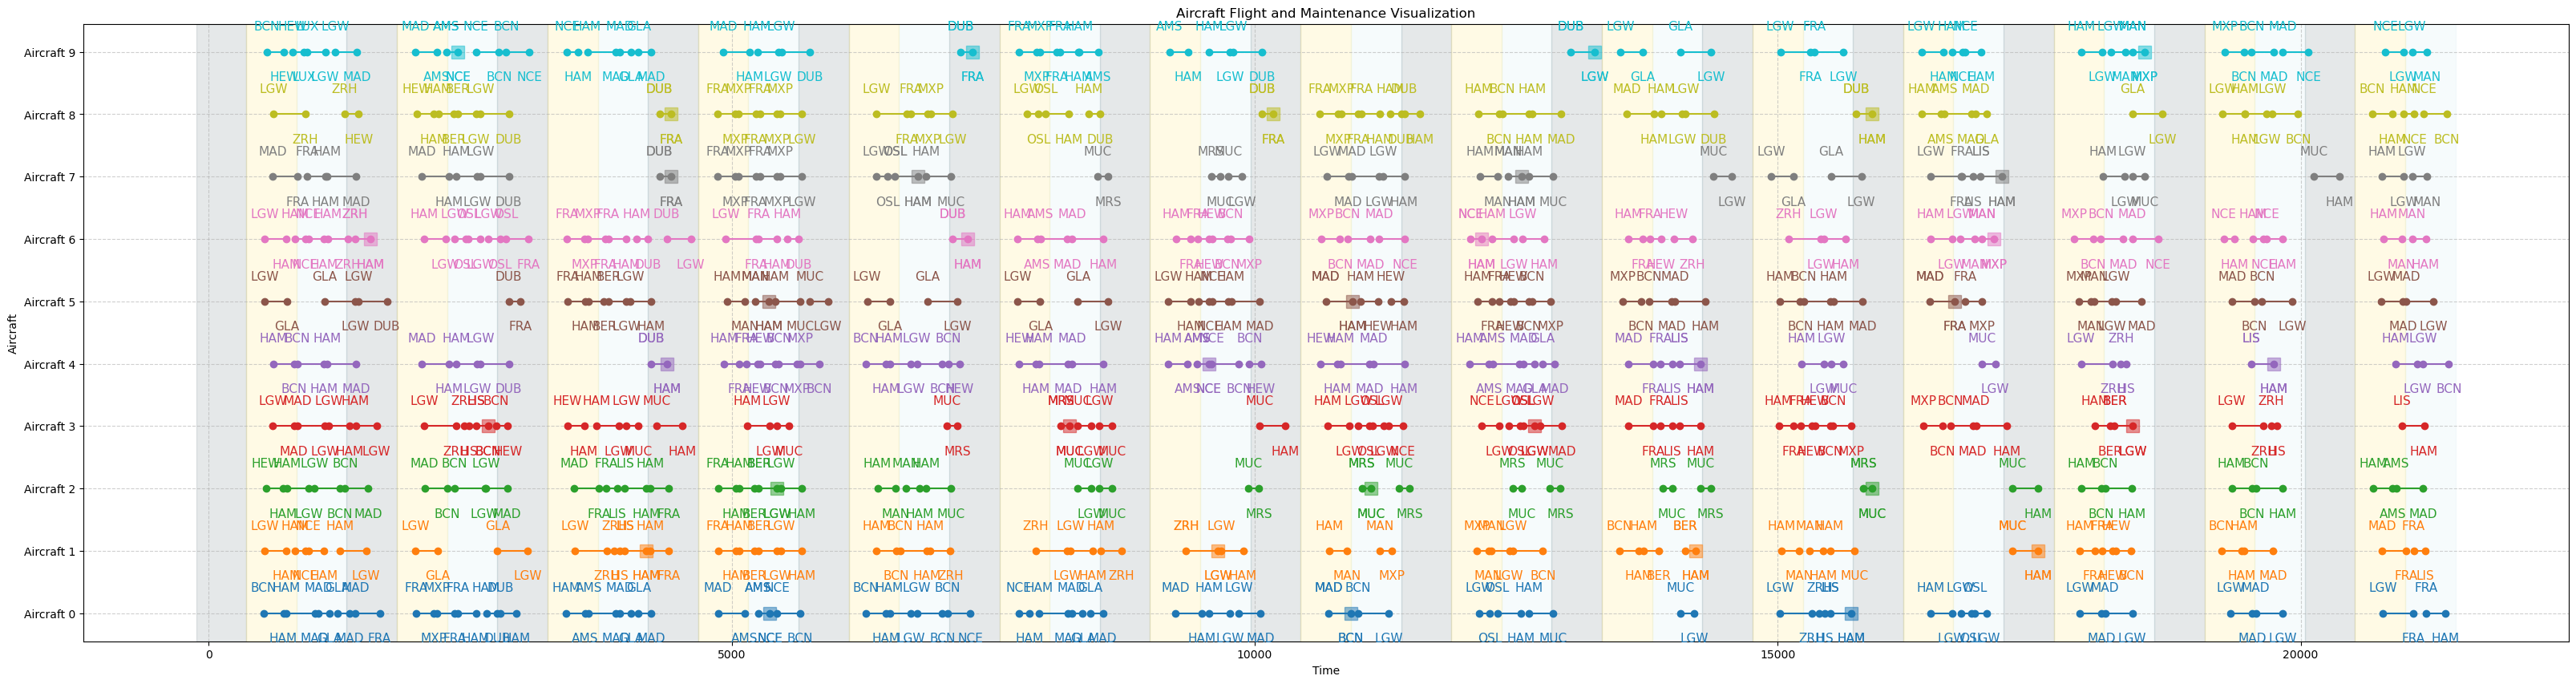

In [11]:
# Define Aircraft Assignments based on Gurobi results
gurobi_vars = [var.x for var in m.getVars()]
X=gurobi_vars[:len(Aircrafts)*len(Flights)] 
Z=gurobi_vars[len(Aircrafts)*len(Flights):]
print(len(X)==len(Z))

flight_assignments = {}
maintenance_assignements = {}
index = 0

for aircraft in Aircrafts:
    for flight in Flights:
        if X[index] == 1.0:
            flight_assignments[flight] = aircraft
        if Z[index] == 1.0:
            maintenance_assignements[flight] = aircraft
        index += 1

# Define colors for each 8-hour period
colors = ['#001f30', '#FFD700', '#ADD8E6']  # Dark blue, Yellow, Light blue

    
def plot_flights_and_maintenance(aircrafts, flight_assignments, maintenance_assignements):
    aircraft_colors = {aircraft: plt.cm.tab10(i % 10) for i, aircraft in enumerate(aircrafts)}
    
    fig, ax = plt.subplots(figsize=(40, 10))
    aircraft_map = {aircraft: i for i, aircraft in enumerate(aircrafts)}
    
    # Shade each 8-hour segment per day
    for day in range(horizon):
        start = day * 24 *60 - 2*60 # Start of the day in hours
        ax.axvspan(start , start + 8*60, color=colors[0], alpha=0.1)   # Night (0-8h)
        ax.axvspan(start + 8*60, start + 16*60, color=colors[1], alpha=0.1)  # Day (8-16h)
        ax.axvspan(start + 16*60, start + 24*60, color=colors[2], alpha=0.1)  # Evening (16-24h)
    
    i=0
    for flight, aircraft in flight_assignments.items():
        color = aircraft_colors[aircraft]
        y_pos = aircraft_map[aircraft]
        ax.plot([DateDep[flight], DateArr[flight]], [y_pos, y_pos], marker='o', color=color, label=aircraft if aircraft not in ax.get_legend_handles_labels()[1] else "")
        ax.text(DateDep[flight], y_pos+0.5, AeroDep[flight], verticalalignment='top', horizontalalignment='center', fontsize=11, color=color)
        ax.text(DateArr[flight], y_pos-0.5, AeroArr[flight], verticalalignment='bottom', horizontalalignment='center', fontsize=11, color=color)
    
    for flight, aircraft in maintenance_assignements.items():
        color = aircraft_colors[aircraft]
        y_pos = aircraft_map[aircraft]
        ax.plot(DateArr[flight], y_pos, marker='s',markersize=12, color=color, linestyle='--',alpha=0.5, label=aircraft if aircraft not in ax.get_legend_handles_labels()[1] else "")
        ax.text(DateDep[flight], y_pos+0.5, AeroDep[flight], verticalalignment='top', horizontalalignment='center', fontsize=11, color=color)
        ax.text(DateArr[flight], y_pos-0.5, AeroArr[flight], verticalalignment='bottom', horizontalalignment='center', fontsize=11, color=color)

    ax.set_yticks(range(len(aircrafts)))
    ax.set_yticklabels([f"Aircraft {ac}" for ac in aircrafts])
    ax.set_xlabel("Time")
    ax.set_ylabel("Aircraft")
    ax.set_title("Aircraft Flight and Maintenance Visualization")
    #ax.legend(title="Aircrafts")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_flights_and_maintenance(Aircrafts, flight_assignments, maintenance_assignements)


In [ ]:

def parse_flight_assignments(file_path=None, a=4, d=1, p=10, h=15, t=0):
    flight_assignments = {}
    maintenance_assignements = {}
    aircraft = None
    if file_path is not None:
        with open(file_path, "r", encoding="utf-8") as f:
            data = f.readlines()  # Liste des lignes du fichier
    else:
        file_path = (
            f"d={a}\\Optimal_Solution_density={d}_p={p}_h={h}_test_{t}.txt"
        )
    
    with open(file_path, 'r', encoding='latin-1') as file:



        for line in file:
            if "Flights assigned to aircraft" in line:
                aircraft = int(re.search(r'\d+', line).group())
            elif "Flight n°" in line:
                match = re.search(r'<(\d+)\s+"(\w+)"\s+"(\w+)"\s+(\d+)\s+(\d+)\s+(\d+)> (\d+)', line)
                if match:
                    flight_id, dep, arr, dep_time, arr_time = match.groups()[:5]
                    flight_assignments[int(flight_id)] = {
                        'aircraft': aircraft,
                        'departure_airport': dep,
                        'arrival_airport': arr,
                        'departure_time': int(dep_time),
                        'arrival_time': int(arr_time)
                    }
        current_plane = None
        if line.startswith("Plane"):
            current_plane = int(line.split()[1])
        elif line.startswith("("):
            parts = line.strip("() ").split()
            flight = int(parts[1])
            maintenance_assignements[flight] = current_plane
    
    
    return flight_assignments , maintenance_assignements

print(parse_flight_assignments(a=4, d=1, p=10, h=15, t=0))

def plot_flights_opt(flight_assignments):
    aircrafts = sorted(set(f['aircraft'] for f in flight_assignments.values()))
    aircraft_colors = {aircraft: plt.cm.tab10(i % 10) for i, aircraft in enumerate(aircrafts)}
    aircraft_map = {aircraft: i for i, aircraft in enumerate(aircrafts)}
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for flight, data in flight_assignments.items():
        color = aircraft_colors[data['aircraft']]
        y_pos = aircraft_map[data['aircraft']]
        ax.plot([DateDep[flight], DateArr[flight]], [y_pos, y_pos], marker='o', color=color)
        ax.text(DateDep[flight], y_pos, AeroDep[flight], verticalalignment='top', horizontalalignment='right', fontsize=10, color=color)
        ax.text(DateArr[flight], y_pos, AeroDep[flight], verticalalignment='bottom', horizontalalignment='left', fontsize=10, color=color)
    
    ax.set_yticks(range(len(aircrafts)))
    ax.set_yticklabels([f"Aircraft {ac}" for ac in aircrafts])
    ax.set_xlabel("Time")
    ax.set_ylabel("Aircraft")
    ax.set_title("Aircraft Flight Visualization from the optimal solution file")
    
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

({}, {330: None})


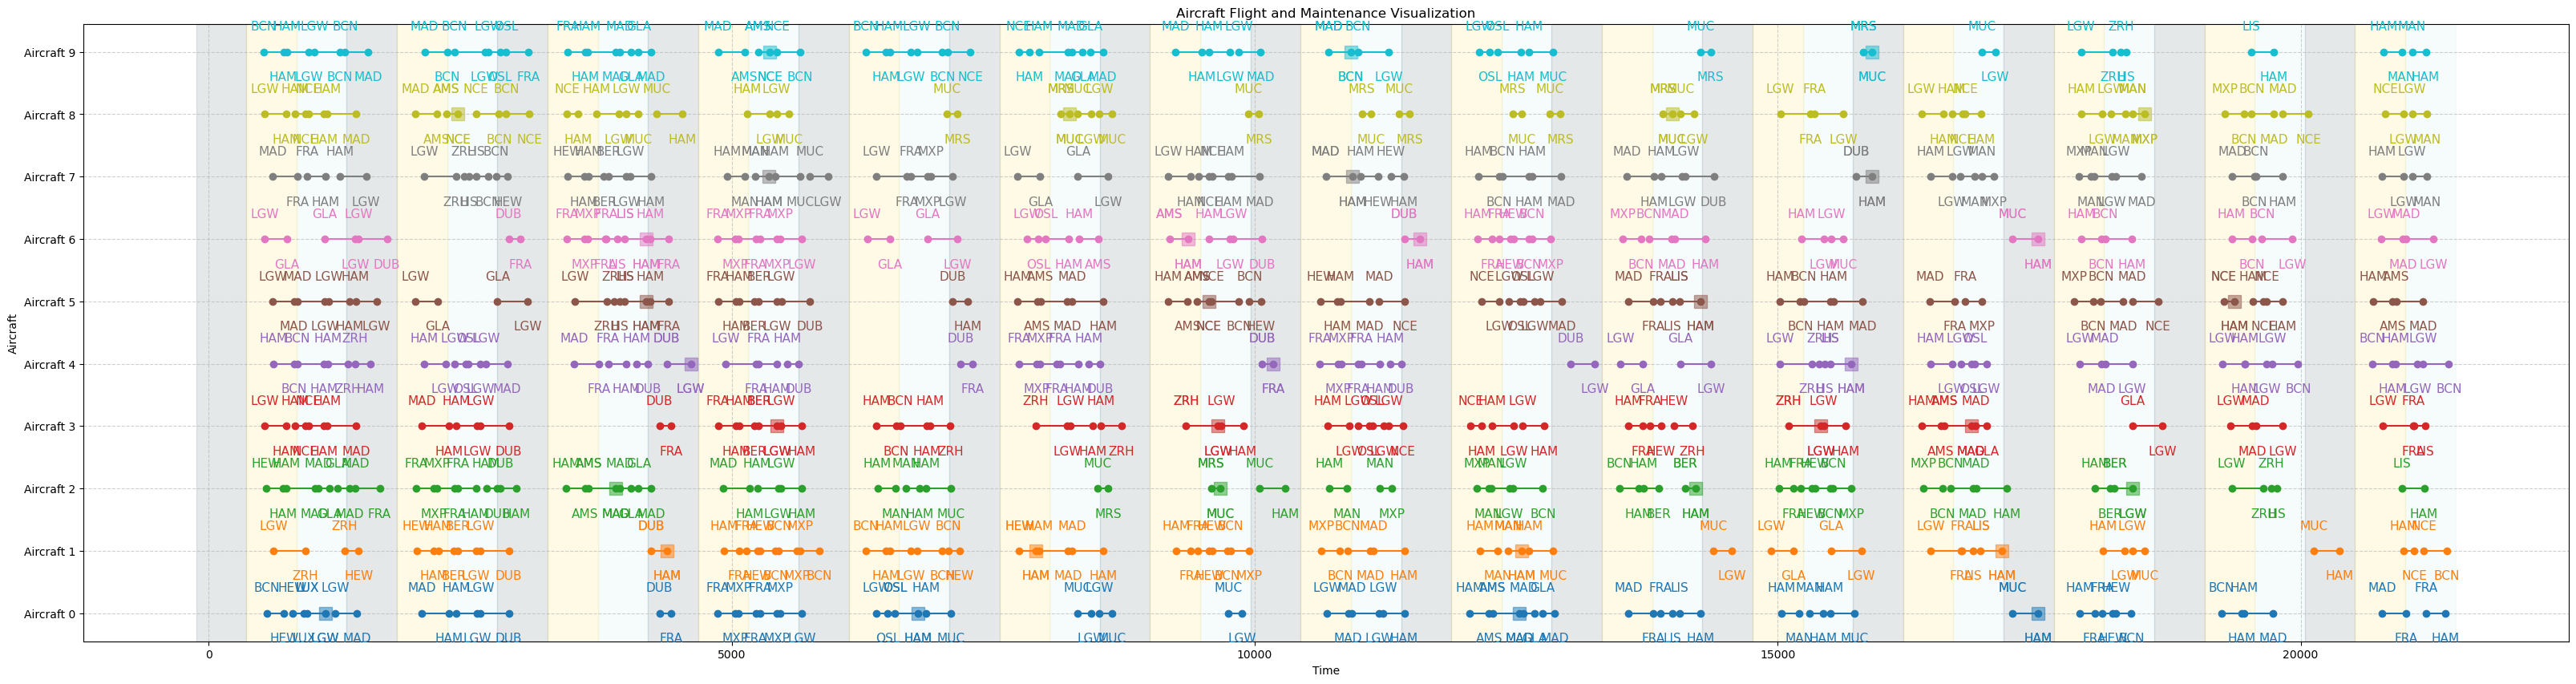

In [ ]:
# Define Aircraft Assignments based on Gurobi results
flight_assignments__, maintenance_assignements__ = parse_flight_assignments(a=4, d=1, p=10, h=15, t=0)

index = 0

for aircraft in Aircrafts:
    for flight in Flights:
        if X[index] == 1.0:
            flight_assignments__[flight] = aircraft
        if Z[index] == 1.0:
            maintenance_assignements__[flight] = aircraft
        index += 1

# Define colors for each 8-hour period
colors = ['#001f30', '#FFD700', '#ADD8E6']  # Dark blue, Yellow, Light blue

    
def plot_flights_and_maintenance(aircrafts, flight_assignments, maintenance_assignements):
    aircraft_colors = {aircraft: plt.cm.tab10(i % 10) for i, aircraft in enumerate(aircrafts)}
    
    fig, ax = plt.subplots(figsize=(40, 10))
    aircraft_map = {aircraft: i for i, aircraft in enumerate(aircrafts)}
    
    # Shade each 8-hour segment per day
    for day in range(horizon):
        start = day * 24 *60 - 2*60 # Start of the day in hours
        ax.axvspan(start , start + 8*60, color=colors[0], alpha=0.1)   # Night (0-8h)
        ax.axvspan(start + 8*60, start + 16*60, color=colors[1], alpha=0.1)  # Day (8-16h)
        ax.axvspan(start + 16*60, start + 24*60, color=colors[2], alpha=0.1)  # Evening (16-24h)
    
    i=0
    for flight, aircraft in flight_assignments.items():
        color = aircraft_colors[aircraft]
        y_pos = aircraft_map[aircraft]
        ax.plot([DateDep[flight], DateArr[flight]], [y_pos, y_pos], marker='o', color=color, label=aircraft if aircraft not in ax.get_legend_handles_labels()[1] else "")
        ax.text(DateDep[flight], y_pos+0.5, AeroDep[flight], verticalalignment='top', horizontalalignment='center', fontsize=11, color=color)
        ax.text(DateArr[flight], y_pos-0.5, AeroArr[flight], verticalalignment='bottom', horizontalalignment='center', fontsize=11, color=color)
    
    for flight, aircraft in maintenance_assignements.items():
        color = aircraft_colors[aircraft]
        y_pos = aircraft_map[aircraft]
        ax.plot(DateArr[flight], y_pos, marker='s',markersize=12, color=color, linestyle='--',alpha=0.5, label=aircraft if aircraft not in ax.get_legend_handles_labels()[1] else "")
        ax.text(DateDep[flight], y_pos+0.5, AeroDep[flight], verticalalignment='top', horizontalalignment='center', fontsize=11, color=color)
        ax.text(DateArr[flight], y_pos-0.5, AeroArr[flight], verticalalignment='bottom', horizontalalignment='center', fontsize=11, color=color)

    ax.set_yticks(range(len(aircrafts)))
    ax.set_yticklabels([f"Aircraft {ac}" for ac in aircrafts])
    ax.set_xlabel("Time")
    ax.set_ylabel("Aircraft")
    ax.set_title("Aircraft Flight and Maintenance Visualization")
    #ax.legend(title="Aircrafts")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_flights_and_maintenance(Aircrafts, flight_assignments__, maintenance_assignements__)


In [10]:
def plot_Aero_maintenance(maintenance_assignements,Aero):
    aeroports_colors = {aerport: plt.cm.tab10(i % 10) for i, aerport in enumerate(Aero)}
    
    fig, ax = plt.subplots(figsize=(40, 10))
    aeroports_map = {aeroport: i for i, aeroport in enumerate(Aero)}
    
    for flight, aircraft in maintenance_assignements.items():
        color = aeroports_colors[aircraft]
        y_pos = aeroports_map[]
        ax.scatter([DateDep[flight], DateArr[flight]], [y_pos, y_pos], marker='o', color=color, label=aircraft if aircraft not in ax.get_legend_handles_labels()[1] else "")
        ax.text(DateArr[flight], y_pos-0.5, aircraft, verticalalignment='bottom', horizontalalignment='center', fontsize=11, color=color)
    
    ax.set_yticks(range(len(Aero)))
    ax.set_yticklabels([f"Aeroport {ac}" for ac in Aero])
    ax.set_xlabel("Time")
    ax.set_ylabel("Aerports")
    #ax.set_title("Aircraft Flight and Maintenance Visualization")
    #ax.legend(title="Aircrafts")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

SyntaxError: invalid syntax (3321343663.py, line 9)